# Spatial Augmentation Example - Random Values

The first thing is to load the necessary packages and set the random seed for reproducibility.

Note: `matplotlip` is not a requirement for the `medipt` package, but it is used here to visualize the results. You can ignore `matplotlib` and simple save the image and/or segmentations and open them in another viewer or your choosing. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import medipt
import SimpleITK as sitk
import random

seed = 42

random.seed(seed)
np.random.seed(seed)

Load the sample image. This image comes from the [VerSe](https://github.com/anjany/verse) spine segmentation dataset. This is a 3D spine segmentation and identification challenge dataset of 3D CT spines.

In [18]:
image = sitk.ReadImage('verse260.nii.gz')
seg = sitk.ReadImage('verse260_seg.nii.gz')

print('size:', image.GetSize())
print('spacing:', image.GetSpacing())
print('direction:', image.GetDirection())
print('origin:', image.GetOrigin())

size: (196, 546, 61)
spacing: (1.0, 1.0, 2.0)
direction: (7.929511846977472e-08, 8.748137356131643e-08, -0.9999999999999931, 0.995192868658119, 0.097934438130913, 8.74813750328934e-08, -0.09793443813091307, 0.9951928686581183, 7.929511980364569e-08)
origin: (60.0, -292.965087890625, -964.2619018554688)


The next step is not necessary, but first we will reorient the image and segmentation.

In [19]:
reorient_filter = sitk.DICOMOrientImageFilter()
reorient_filter.SetDesiredCoordinateOrientation('LPS')

original_orientation = reorient_filter.GetOrientationFromDirectionCosines(image.GetDirection())

image = reorient_filter.Execute(image)
seg = reorient_filter.Execute(seg)

Now, we are going to define our augmentation and resampling parameters. For this example, we are going to resample the image to a isovoxel spacing of 1x1x1 mm and to an output shape of 256 by 256 by 512. We are going to keep the same direction and origin as the original image. 

As we have a 3D image, `dim=3`.

Note: The overall transforms are generated using the `medipt.transforms.generate_sitk_transform` function. One of the parameters is `legacy_random_state`, which is set to `True` by default. In newer versions of `numpy`, which is used to generate the random transform parameters, has a newer mechanism for how random numbers are generated. This will not go into this here, but just note that is what the argument does. 

Also, since we defined the seed above, we do not need to pass the seed into `medipt.transforms.generate_sitk_transform`. The seed can be passed through as well, and the result will be the same. For simplicity, if seed is globally defined, the `seed` argument should be left as `None` and the `legacy_random_state` is defined as `True`. 

The `seed` should only be passed if it is defined as a `np.random.Generator` or `np.random.BitGenerator` and `legacy_random_state` is set to `False`.
 

In [20]:
image_size = (256, 256, 512)
resample_spacing = (1, 1, 1)

dim = 3

spatial_params = {}
spatial_params['input_size'] = image.GetSize()
spatial_params['input_spacing'] = image.GetSpacing()
spatial_params['input_origin'] = image.GetOrigin()
spatial_params['input_direction'] = image.GetDirection()

spatial_params['output_size'] = image_size
spatial_params['output_spacing'] = resample_spacing
spatial_params['output_origin'] = image.GetOrigin()
spatial_params['output_direction'] = image.GetDirection()


spatial_params['random_rotation'] = [0.25, 0.25, 0.25]
spatial_params['random_translation'] = [30, 30, 30]
spatial_params['random_scaling'] = [0.15, 0.15, 0.15]
spatial_params['random_uniform_scaling'] = 0.15
spatial_params['random_flipping'] = [1, 0, 0]


spatial_params['random_elastic_deformation'] = True
spatial_params['max_deformation'] = [25, 25, 25]
spatial_params['num_grid_points'] = [6, 6, 6]
spatial_params['spline_order'] = 3


medipt_composite_transform, transform_list = medipt.transforms.generate_sitk_transform(params=spatial_params,
                                                                                       dim=dim,
                                                                                       seed=seed,
                                                                                       legacy_random_state=True)



Initialize the resample functions for both the image and the segmentation. This allows us to have slightly different parameters for both, like the `default_pixel_value`, `pixel_type`, and the `interpolator`. The image resample could use different interpolators but the segmentation resampler should always use `nearest` to keep the output strictly integer. 

In [21]:
image_resampler = medipt.resample_image.ResampleImage(interpolator='linear',
                                post_processing_sitk=None,
                                dim=dim,
                                default_pixel_value=-1024,
                                )

seg_resampler = medipt.resample_image.ResampleImage(interpolator='nearest',
                              post_processing_sitk=None,
                              dim=dim,
                              pixel_type=sitk.sitkUInt8,
                              default_pixel_value=0,
                              )

Need to convert the `medipt_composite_transform` to a `sitk.Transform` object to use in the resample functions.

In [22]:
composite_transform = medipt_composite_transform.create_composite(dim)

Put it all together

In [23]:
resampled_img = image_resampler.get_resampled_images(image, transform=composite_transform,
                                                     input_output_space_dict=spatial_params)

resampled_seg = seg_resampler.get_resampled_images(seg, transform=composite_transform,
                                                   input_output_space_dict=spatial_params)

In [24]:
from matplotlib.colors import ListedColormap, Normalize
import numpy as np

colors_itk = (1 / 255) * np.array([
    [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [0, 255, 255],
    [255, 0, 255], [255, 239, 213],  # Label 1-7 (C1-7)
    [0, 0, 205], [205, 133, 63], [210, 180, 140], [102, 205, 170], [0, 0, 128],
    [0, 139, 139], [46, 139, 87], [255, 228, 225], [106, 90, 205], [221, 160, 221],
    [233, 150, 122], [165, 42, 42],  # Label 8-19 (T1-12)
    [255, 250, 250], [147, 112, 219], [218, 112, 214], [75, 0, 130], [255, 182, 193],
    [60, 179, 113], [255, 235, 205],  # Label 20-26 (L1-6, sacrum)
    [255, 235, 205], [255, 228, 196],  # Label 27 cocc, 28 T13,
    [218, 165, 32], [0, 128, 128], [188, 143, 143], [255, 105, 180],
    [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [0, 255, 255],
    [255, 0, 255], [255, 239, 213],  # 29-39 unused
    [0, 0, 205], [205, 133, 63], [210, 180, 140], [102, 205, 170], [0, 0, 128],
    [0, 139, 139], [46, 139, 87], [255, 228, 225], [106, 90, 205], [221, 160, 221],
    [233, 150, 122],  # Label 40-50 (subregions)
    [255, 250, 250], [147, 112, 219], [218, 112, 214], [75, 0, 130], [255, 182, 193],
    [60, 179, 113], [255, 235, 205], [255, 105, 180], [165, 42, 42], [188, 143, 143],
    [255, 235, 205], [255, 228, 196], [218, 165, 32], [0, 128, 128]  # rest unused
])
cm_itk = ListedColormap(colors_itk)
cm_itk.set_bad(color='w', alpha=0)

wdw_sbone = Normalize(vmin=-500, vmax=1300, clip=True)
wdw_hbone = Normalize(vmin=-200, vmax=1000, clip=True)

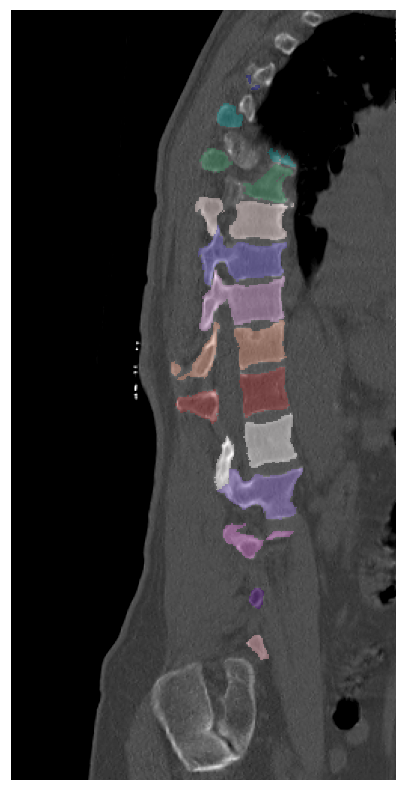

In [25]:
sagittal_slice = 140

image_np = sitk.GetArrayFromImage(resampled_img)
seg_np = sitk.GetArrayFromImage(resampled_seg)

seg_mask = np.ma.masked_where(seg_np < 0.9, seg_np)

image_slice = image_np[:, :, sagittal_slice]
seg_slice = seg_mask[:, :, sagittal_slice]

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)


ax.imshow(image_slice, cmap='gray', norm=wdw_sbone)
ax.imshow(seg_slice, interpolation='none', alpha=0.4, cmap=cm_itk, vmin=1, vmax=65)

bottom = 0
top = image_np.shape[0]

axis_crop_min = 0
axis_crop_max = 256

ax.set_ylim(bottom=bottom, top=top)
ax.set_xlim(left=axis_crop_max, right=axis_crop_min)
ax.axis('off')
plt.show()